In [ ]:
## Loading Kaggle API ##
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


# **Importing Pacakges**

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

# **Importing the Dataset**



*   Downloading via Kaggle API.
*   Importing the CSV file.



In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cd /content/dataset

/content/dataset


In [ ]:
! kaggle datasets download -d zynicide/wine-reviews
! unzip /content/dataset/wine-reviews.zip

 49% 25.0M/50.9M [00:00<00:00, 132MB/s]
100% 50.9M/50.9M [00:00<00:00, 194MB/s]
Archive:  /content/dataset/wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


In [ ]:
cd ..

/content


# **Importing the dataset CSV.**

In [ ]:
df = pd.read_csv('/content/dataset/winemag-data-130k-v2.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
## Checking for empty value cells.

null_cols = df.isna().sum()
null_cols, df.shape

(country          63
 description       0
 points            0
 price          8996
 variety           1
 winery            0
 dtype: int64, (129971, 6))

In [ ]:
df = df.dropna()
df, df.shape

(         country                                        description  points  \
 1       Portugal  This is ripe and fruity, a wine that is smooth...      87   
 2             US  Tart and snappy, the flavors of lime flesh and...      87   
 3             US  Pineapple rind, lemon pith and orange blossom ...      87   
 4             US  Much like the regular bottling from 2012, this...      87   
 5          Spain  Blackberry and raspberry aromas show a typical...      87   
 ...          ...                                                ...     ...   
 129966   Germany  Notes of honeysuckle and cantaloupe sweeten th...      90   
 129967        US  Citation is given as much as a decade of bottl...      90   
 129968    France  Well-drained gravel soil gives this wine its c...      90   
 129969    France  A dry style of Pinot Gris, this is crisp with ...      90   
 129970    France  Big, rich and off-dry, this is powered by inte...      90   
 
         price             variety    

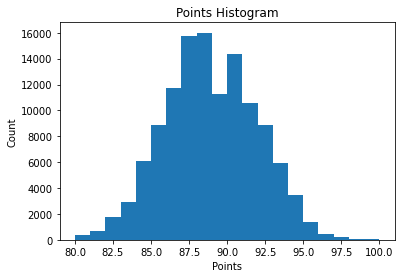

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("Count")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
## create a utility function that converts each training,
##  validation, and test set DataFrame into a tf.data.Dataset, 
##    then shuffles and batches the data.

"""
Code Taken from Tensorflow
"""

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# **Embeddin + Model**

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
## Using a prebuilt traible model from Tensorflow.

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.48694274, -0.02909141,  0.26647836, ...,  0.06781625,
        -0.24981725,  0.15300056],
       [ 0.54130536, -0.0957513 , -0.03660581, ..., -0.26771832,
        -0.23995051, -0.09706313],
       [ 0.40230688, -0.5217516 , -0.07473104, ...,  0.00766842,
        -0.45271516, -0.31508714],
       ...,
       [ 0.02228464, -0.2619719 , -0.22074491, ..., -0.22561152,
        -0.00441646, -0.00984691],
       [ 0.40096134, -0.25660226,  0.01522684, ..., -0.04123865,
        -0.10918563,  0.1627467 ],
       [ 0.17904289, -0.19455701, -0.02851912, ...,  0.09847111,
         0.00355257,  0.0184105 ]], dtype=float32)>

In [ ]:
## Wrtitng the Layers of the Neural Network

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) ## .Dropout function incduces randomsness and teels the model that some nodes are dead/not working/not trainable on, which helps for the problem of overfitting.
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) ## .Dropout function incduces randomsness and teels the model that some nodes are dead/not working/not trainable on, which helps for the problem of overfitting.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                 loss = tf.keras.losses.BinaryCrossentropy(),
                                                 metrics=['accuracy'])

In [ ]:
# Evaluating our model.

model.evaluate(valid_data)

12/12 [==============================] - 0s 8ms/step - loss: 0.6996 - accuracy: 0.4428


[0.6995720267295837, 0.44280868768692017]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data= valid_data)

Epoch 1/5
95/95 [==============================] - 4s 35ms/step - loss: 0.4148 - accuracy: 0.8132 - val_loss: 0.3929 - val_accuracy: 0.8254
Epoch 2/5
95/95 [==============================] - 3s 34ms/step - loss: 0.3310 - accuracy: 0.8610 - val_loss: 0.3957 - val_accuracy: 0.8218
Epoch 3/5
95/95 [==============================] - 3s 34ms/step - loss: 0.2906 - accuracy: 0.8854 - val_loss: 0.4171 - val_accuracy: 0.8196
Epoch 4/5
95/95 [==============================] - 3s 34ms/step - loss: 0.2620 - accuracy: 0.8993 - val_loss: 0.4460 - val_accuracy: 0.8212
Epoch 5/5
95/95 [==============================] - 3s 35ms/step - loss: 0.2396 - accuracy: 0.9104 - val_loss: 0.4823 - val_accuracy: 0.8199


In [ ]:
model.evaluate(test_data)

12/12 [==============================] - 0s 13ms/step - loss: 0.4756 - accuracy: 0.8231


[0.4755927324295044, 0.8231061697006226]

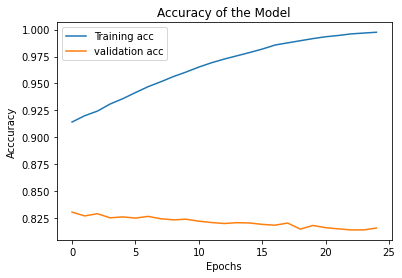

In [ ]:
## Visauzlizingthe Accuracy of the model

plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="validation acc")
plt.title("Accuracy of the Model")
plt.ylabel("Acccuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

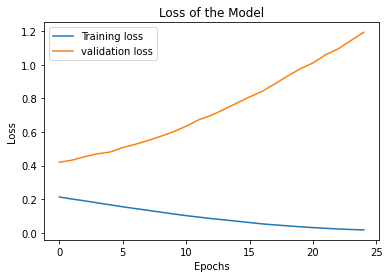

In [ ]:
## Visauzlizingthe Loss of the model

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Loss of the Model")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# **Using LSTM**

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'finish'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile (optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

12/12 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.6024


[0.6923598647117615, 0.6024315357208252]

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
95/95 [==============================] - 7s 30ms/step - loss: 0.5643 - accuracy: 0.6891 - val_loss: 0.3892 - val_accuracy: 0.8192
Epoch 2/10
95/95 [==============================] - 3s 31ms/step - loss: 0.3906 - accuracy: 0.8290 - val_loss: 0.3527 - val_accuracy: 0.8384
Epoch 3/10
95/95 [==============================] - 3s 31ms/step - loss: 0.3663 - accuracy: 0.8435 - val_loss: 0.3445 - val_accuracy: 0.8410
Epoch 4/10
95/95 [==============================] - 3s 29ms/step - loss: 0.3597 - accuracy: 0.8464 - val_loss: 0.3440 - val_accuracy: 0.8391
Epoch 5/10
95/95 [==============================] - 3s 31ms/step - loss: 0.3485 - accuracy: 0.8503 - val_loss: 0.3420 - val_accuracy: 0.8419
Epoch 6/10
95/95 [==============================] - 3s 30ms/step - loss: 0.3443 - accuracy: 0.8507 - val_loss: 0.3434 - val_accuracy: 0.8420
Epoch 7/10
95/95 [==============================] - 3s 30ms/step - loss: 0.3411 - accuracy: 0.8506 - val_loss: 0.3465 - val_accuracy: 0.8415
Epoch 8/10
95

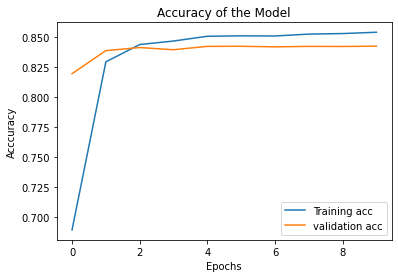

In [ ]:
## Visauzlizingthe Accuracy of the model

plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="validation acc")
plt.title("Accuracy of the Model")
plt.ylabel("Acccuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

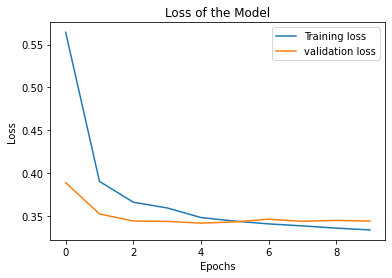

In [ ]:
## Visauzlizingthe Loss of the model

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Loss of the Model")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()